In [125]:
import findspark
from pyspark import SparkContext
from pyspark.sql import SparkSession, Window, Row
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
from pyspark.sql.types import *
import seaborn as sns


import os

# Replace '/path/to/your/java/home' with the actual path where Java is installed
os.environ['JAVA_HOME'] = 'C:\Program Files\Java\jdk-21'


In [50]:

spark = SparkSession.builder.appName("EgyptWinsPieChart").config("spark.driver.memory", "4g").getOrCreate()



## date,home_team,away_team,home_score,away_score,tournament,city,country,neutral


In [51]:
schema = StructType([
    StructField("Date", StringType(), True),
    StructField("HomeTeam", StringType(), True),
    StructField("AwayTeam", StringType(), True),
    StructField("HomeScore", IntegerType(), True),
    StructField("AwayScore", IntegerType(), True),
    StructField("tournament", StringType(), True),
    StructField("city", StringType(), True),
    StructField("country", StringType(), True),
    StructField("neutral", BooleanType(), True)
])

In [52]:
df = spark.read.csv('results.csv',header=True,schema=schema)


In [53]:
df.show()

+----------+----------------+--------+---------+---------+----------+---------+--------+-------+
|      Date|        HomeTeam|AwayTeam|HomeScore|AwayScore|tournament|     city| country|neutral|
+----------+----------------+--------+---------+---------+----------+---------+--------+-------+
|1872-11-30|        Scotland| England|        0|        0|  Friendly|  Glasgow|Scotland|  false|
|1873-03-08|         England|Scotland|        4|        2|  Friendly|   London| England|  false|
|1874-03-07|        Scotland| England|        2|        1|  Friendly|  Glasgow|Scotland|  false|
|1875-03-06|         England|Scotland|        2|        2|  Friendly|   London| England|  false|
|1876-03-04|        Scotland| England|        3|        0|  Friendly|  Glasgow|Scotland|  false|
|1876-03-25|        Scotland|   Wales|        4|        0|  Friendly|  Glasgow|Scotland|  false|
|1877-03-03|         England|Scotland|        1|        3|  Friendly|   London| England|  false|
|1877-03-05|           Wales|S

In [54]:
egypt = df.filter((col("HomeTeam") == "Egypt") | (col("AwayTeam") == "Egypt"))


In [55]:
egypt.show()

+----------+-----------+----------+---------+---------+--------------------+----------------+-----------+-------+
|      Date|   HomeTeam|  AwayTeam|HomeScore|AwayScore|          tournament|            city|    country|neutral|
+----------+-----------+----------+---------+---------+--------------------+----------------+-----------+-------+
|1924-05-27|      Egypt| Lithuania|       10|        0|            Friendly|       Vincennes|     France|   true|
|1924-06-22|    Austria|     Egypt|        3|        1|            Friendly|          Vienna|    Austria|  false|
|1924-06-29|     Sweden|     Egypt|        5|        0|            Friendly|       Stockholm|     Sweden|  false|
|1928-06-14|Netherlands|     Egypt|        1|        2|            Friendly|       Rotterdam|Netherlands|  false|
|1928-06-28| Luxembourg|     Egypt|        1|        1|            Friendly|Esch-sur-Alzette| Luxembourg|  false|
|1932-02-19|      Egypt|   Hungary|        0|        0|            Friendly|           C

### checking nulls and NA

In [56]:
# Use selectExpr and agg to calculate count of null values for each column
na_counts = df.selectExpr([f"sum(int({col} is null or {col} == 'NA')) as {col}_na" for col in df.columns])

# Show the summary of null counts
print("Summary of null counts:")
null_counts.show()



Summary of null counts:
+-------+-----------+-----------+------------+------------+-------------+-------+----------+----------+
|Date_na|HomeTeam_na|AwayTeam_na|HomeScore_na|AwayScore_na|tournament_na|city_na|country_na|neutral_na|
+-------+-----------+-----------+------------+------------+-------------+-------+----------+----------+
|      0|          0|          0|           0|           0|            0|      0|         0|         0|
+-------+-----------+-----------+------------+------------+-------------+-------+----------+----------+



In [57]:
EGYPT = "Egypt"

df_with_winner = egypt.withColumn(
    "Winner",
    when((col("HomeScore") > col("AwayScore")) & (col("HomeTeam") == EGYPT), "Egypt Wins")
    .when((col("HomeScore") < col("AwayScore")) & (col("AwayTeam") == EGYPT), "Egypt Wins")
    .when((col("HomeScore") == col("AwayScore")) & (col("HomeTeam") == EGYPT), "Egypt Draws")
    .when((col("HomeScore") == col("AwayScore")) & (col("AwayTeam") == EGYPT), "Egypt Draws")
    .otherwise("Egypt Loses")
)

In [58]:
df_with_winner.show()

+----------+-----------+----------+---------+---------+--------------------+----------------+-----------+-------+-----------+
|      Date|   HomeTeam|  AwayTeam|HomeScore|AwayScore|          tournament|            city|    country|neutral|     Winner|
+----------+-----------+----------+---------+---------+--------------------+----------------+-----------+-------+-----------+
|1924-05-27|      Egypt| Lithuania|       10|        0|            Friendly|       Vincennes|     France|   true| Egypt Wins|
|1924-06-22|    Austria|     Egypt|        3|        1|            Friendly|          Vienna|    Austria|  false|Egypt Loses|
|1924-06-29|     Sweden|     Egypt|        5|        0|            Friendly|       Stockholm|     Sweden|  false|Egypt Loses|
|1928-06-14|Netherlands|     Egypt|        1|        2|            Friendly|       Rotterdam|Netherlands|  false| Egypt Wins|
|1928-06-28| Luxembourg|     Egypt|        1|        1|            Friendly|Esch-sur-Alzette| Luxembourg|  false|Egypt

In [59]:
df_egypt_wins=df_with_winner.filter(col("Winner")=="Egypt Wins")

In [60]:
df_egypt_wins.show()

+----------+-----------+-------------+---------+---------+--------------------+-----------+--------------------+-------+----------+
|      Date|   HomeTeam|     AwayTeam|HomeScore|AwayScore|          tournament|       city|             country|neutral|    Winner|
+----------+-----------+-------------+---------+---------+--------------------+-----------+--------------------+-------+----------+
|1924-05-27|      Egypt|    Lithuania|       10|        0|            Friendly|  Vincennes|              France|   true|Egypt Wins|
|1928-06-14|Netherlands|        Egypt|        1|        2|            Friendly|  Rotterdam|         Netherlands|  false|Egypt Wins|
|1934-03-16|      Egypt|       Israel|        7|        1|FIFA World Cup qu...|      Cairo|               Egypt|  false|Egypt Wins|
|1934-04-06|     Israel|        Egypt|        1|        4|FIFA World Cup qu...|   Tel Aviv|           Palestine|  false|Egypt Wins|
|1936-06-19|      Egypt|       Greece|        3|        1|            Friend

### how many times did egypt win?

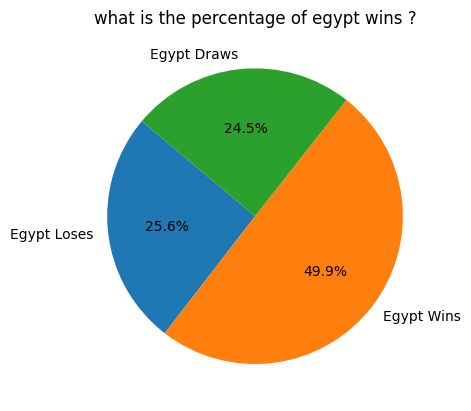

In [64]:
total_matches_count = df_with_winner.count()
egypt_wins_count = df_with_winner.filter(col("Winner") == "Egypt Wins").count()

# Create a new DataFrame with counts for pie chart
data_for_pie = [(egypt_wins_count, "Egypt Wins"), (total_matches_count - egypt_wins_count, "Other")]

# Aggregate data for the pie chart
pie_data = df_with_winner.groupBy("Winner").count().toPandas()

# Plot the pie chart
plt.pie(pie_data["count"], labels=pie_data["Winner"], autopct='%1.1f%%', startangle=140)
plt.title("what is the percentage of egypt wins ?")
plt.show()

## now we know the winning rate lets try to figure out what was egypt's best and worst years


In [66]:
df_egypt_wins=df_egypt_wins.withColumn("Date", df_egypt_wins["Date"].cast("date"))

In [69]:
df_egypt_wins_years=df_egypt_wins.withColumn("Year", year("Date"))

In [111]:
result = df_egypt_wins_years.groupBy("Year").count()
df_egypt_wins_years.createOrReplaceTempView("egypt_wins_years_view")
query = """
    SELECT Year, COUNT(*) as count
    FROM egypt_wins_years_view
    GROUP BY Year
    ORDER BY count DESC
    LIMIT 20
"""

top_10_years_df = spark.sql(query)

query = """
    SELECT Year, COUNT(*) as count
    FROM egypt_wins_years_view
    GROUP BY Year
    ORDER BY count
    LIMIT 20
"""

bottom_10_years_df = spark.sql(query)



In [112]:
bottom_10_years_df.show()

+----+-----+
|Year|count|
+----+-----+
|1924|    1|
|1955|    1|
|1979|    1|
|1950|    1|
|1949|    1|
|1936|    1|
|1958|    1|
|1964|    1|
|1928|    1|
|1959|    2|
|1934|    2|
|1967|    2|
|1969|    2|
|1987|    2|
|1980|    2|
|1981|    2|
|1962|    2|
|2007|    3|
|1973|    3|
|1957|    3|
+----+-----+



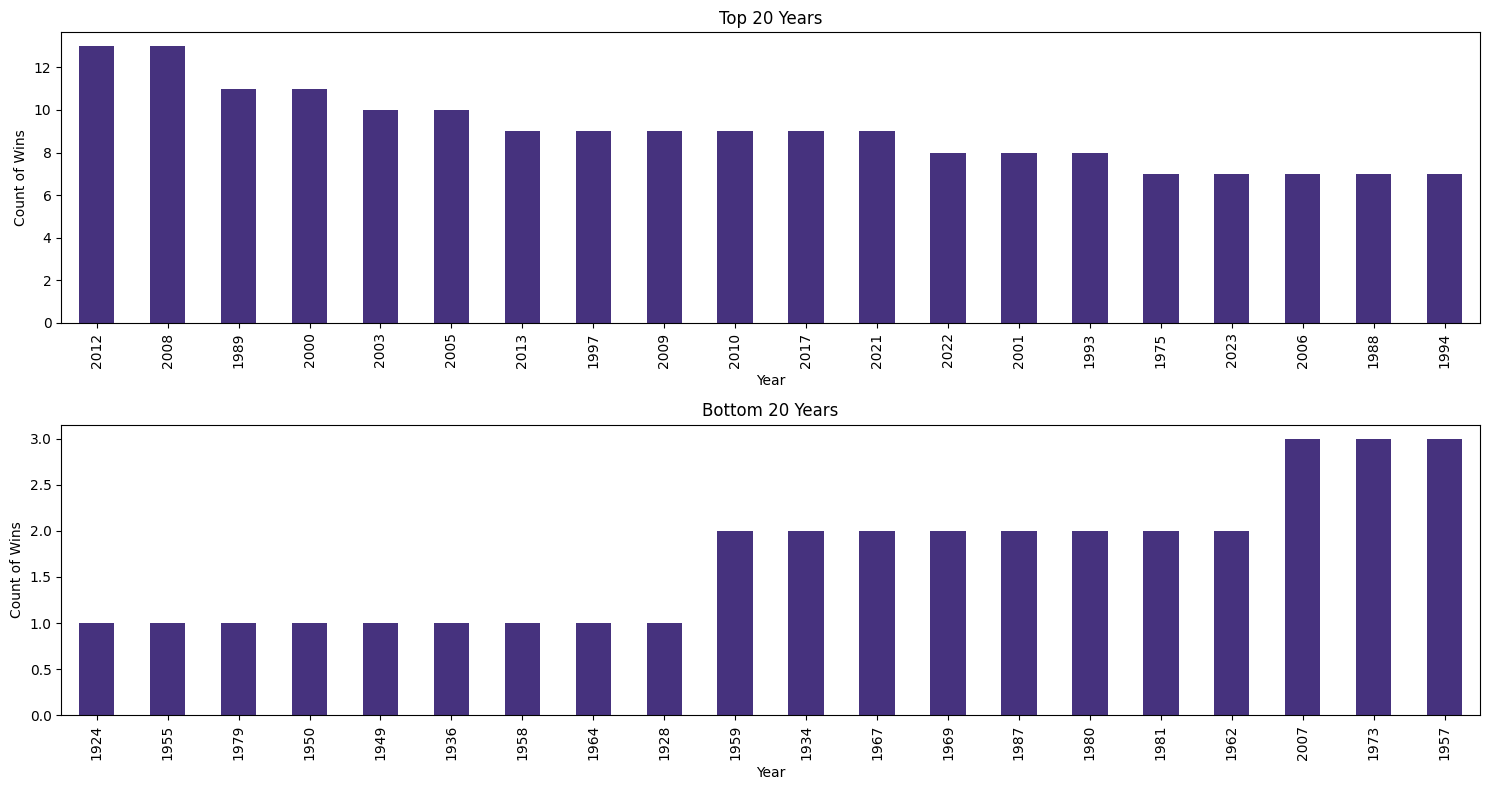

In [142]:
plt.figure(figsize=(15, 8))

# Plot for the top 10 years
plt.subplot(2, 1, 1)
top_10_years_df.toPandas().plot(kind="bar", y="count", x="Year", legend=False, ax=plt.gca())
plt.ylabel("Count of Wins")
plt.title("Top 20 Years")

# Plot for the bottom 10 years
plt.subplot(2, 1, 2)
bottom_10_years_df.toPandas().plot(kind="bar", y="count", x="Year", legend=False, ax=plt.gca())
plt.ylabel("Count of Wins")
plt.title("Bottom 20 Years")

plt.tight_layout()

# Show the plot
plt.show()

### lets see top 20 scores egypt scored in a single match

In [120]:
score_df = df_egypt_wins_years.withColumn(
    "score",
    when(col("HomeScore") > col("AwayScore"), col("HomeScore"))
    .when(col("HomeScore") < col("AwayScore"), col("AwayScore")))
    

In [140]:
score_df.createOrReplaceTempView("scores_view")
query = """
    SELECT score
    FROM scores_view
    GROUP BY score
    ORDER BY score DESC
    LIMIT 20
"""

top_20_scores = spark.sql(query)



In [130]:
top_20_scores.show()

+-----+
|score|
+-----+
|   15|
|   10|
|    8|
|    7|
|    6|
|    5|
|    4|
|    3|
|    2|
|    1|
+-----+



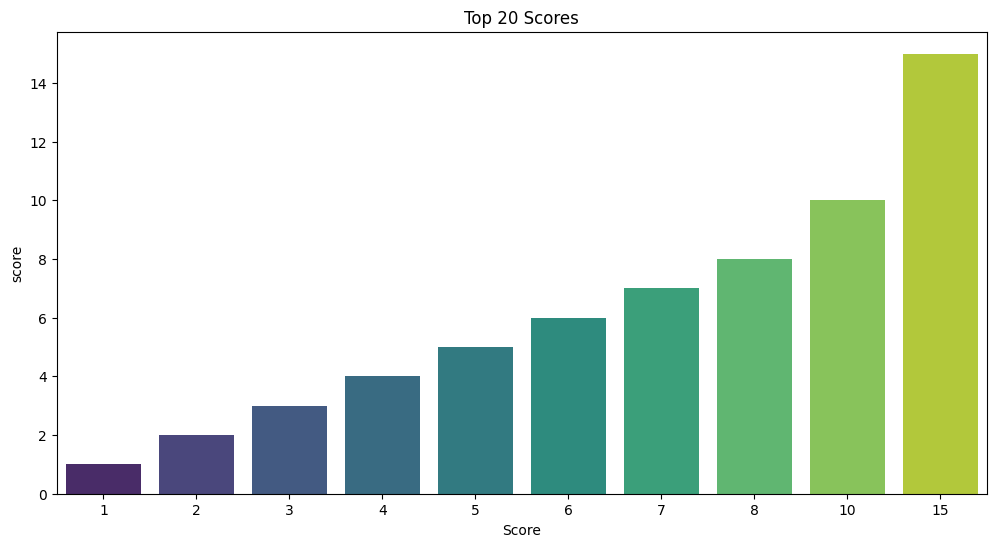

In [141]:
import seaborn as sns

# Set a color palette for the plot
sns.set_palette("viridis")

plt.figure(figsize=(12, 6))
sns.barplot(x=top_20_scores_pandas['score'], y=top_20_scores_pandas['score'], palette="viridis")
plt.xlabel('Score')
plt.title('Top 20 Scores')
plt.show()


## since 2011 what was the trend of the egyptian national team?

In [153]:
df_with_winner=df_with_winner.withColumn("Date", df_with_winner["Date"].cast("date"))
df_with_winner=df_with_winner.withColumn("Year", year("Date"))
df_with_winner = df_with_winner.withColumn(
    "Points",
    when(col("Winner") == "Egypt Wins", 3)
    .when(col("Winner") == "Egypt Draws", 1)
    .otherwise(0)
)


trend_df = df_with_winner.filter(col("Year").between(2011, 2023))
# Group by Year and sum the total points
points_trend_data = trend_df.groupBy("Year").agg(
    sum("Points").alias("Total Points")
)

# Convert to Pandas for plotting
pandas_points_trend_data = points_trend_data.toPandas()

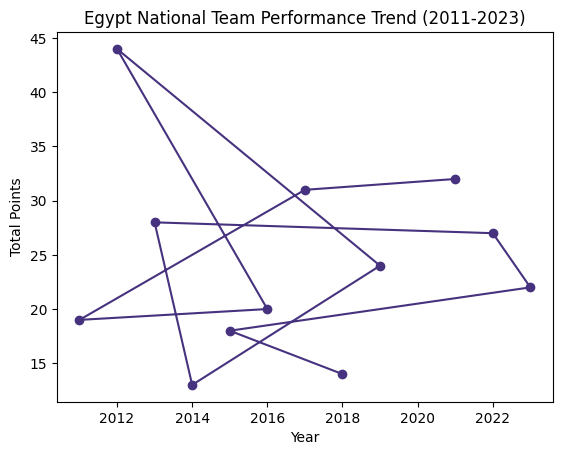

In [156]:
# Plotting
plt.plot(pandas_points_trend_data["Year"], pandas_points_trend_data["Total Points"], marker='o')

plt.xlabel("Year")
plt.ylabel("Total Points")
plt.title("Egypt National Team Performance Trend (2011-2023)")
plt.show()